In [1]:
%load_ext autoreload
%autoreload 2

import os

import xarray as xr

from mjonet.data import era5
from mjonet.viz import plot_era5

from dask.distributed import Client, LocalCluster, progress
cluster = LocalCluster(n_workers=4)
client = Client(cluster) 

### Preprocess some of the variables.

In [2]:
%%time

dset = era5.preprocess('mtnlwrf', 'r', 'z', plevels={'r': [200, 500], 'z': [200]}, 
                       year_or_range=1988, parallel=True, verbose=True)

dset

Processing 756 files...
Datasets opened and combined. Removing missing times...
Missing times removed. Subsampling and regridding...
CPU times: user 6.65 s, sys: 1.2 s, total: 7.85 s
Wall time: 55.7 s


<xarray.Dataset>
Dimensions:   (time: 1463, lat: 721, lon: 1440, r_level: 2, z_level: 1)
Coordinates:
  * time      (time) datetime64[ns] 1988-01-01T07:00:00 ... 1988-12-31T19:00:00
  * lat       (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon       (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * r_level   (r_level) float64 200.0 500.0
  * z_level   (z_level) float64 200.0
Data variables:
    MTNLWRF   (time, lat, lon) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    R         (time, r_level, lat, lon) float32 dask.array<chunksize=(3, 2, 721, 1440), meta=np.ndarray>
    utc_date  (time) float64 dask.array<chunksize=(3,), meta=np.ndarray>
    Z         (time, z_level, lat, lon) float32 dask.array<chunksize=(3, 1, 721, 1440), meta=np.ndarray>

### Compare processed data with original.

Get original data.

In [3]:
fnames = era5.get_filenames('mtnlwrf', 'r', 'z', year_or_range=1988)

mtnlwrf = xr.open_dataset(fnames['mtnlwrf'][0])
r = xr.open_dataset(fnames['r'][0])
z = xr.open_dataset(fnames['z'][0])

Compare original and preprocessed.

mtnlwrf times match
1988-01-01T07:00:00.000000000
1988-01-01T07:00:00.000000000 

r times match
1988-01-01T07:00:00.000000000
1988-01-01T07:00:00.000000000 

z times match
1988-01-01T07:00:00.000000000
1988-01-01T07:00:00.000000000 

plots match


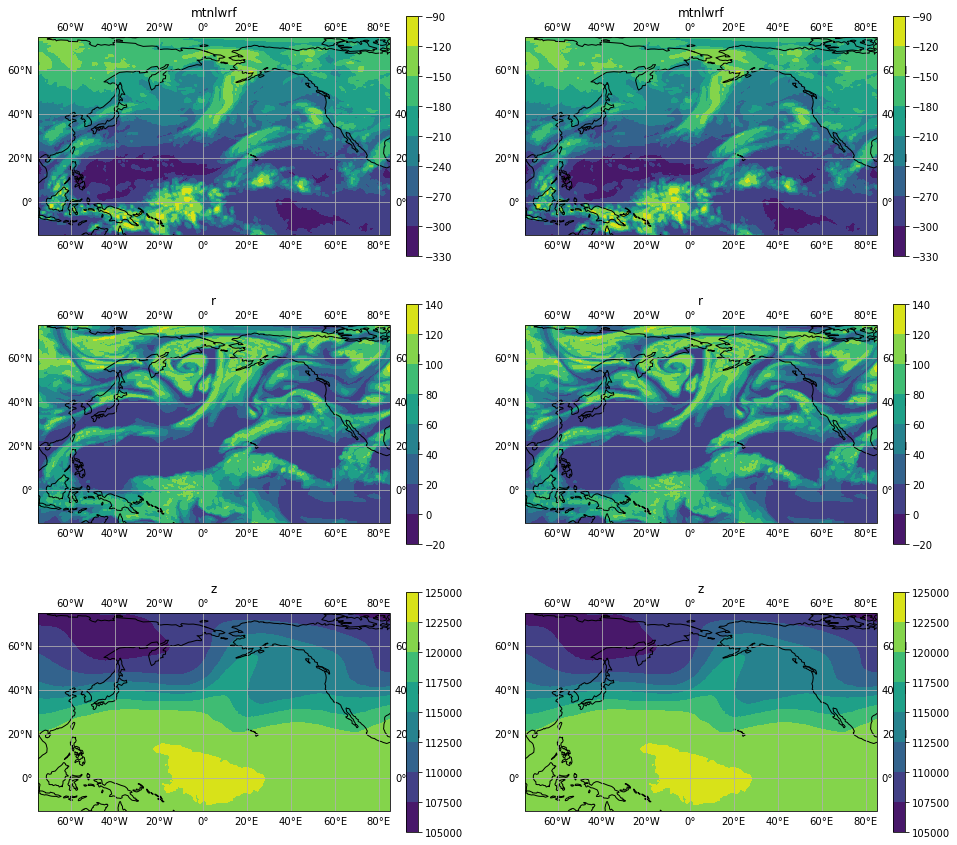

In [4]:
print('mtnlwrf times match')
print(dset['MTNLWRF']['time'][0].data)
print(mtnlwrf['forecast_initial_time'][0].data + mtnlwrf['forecast_hour'][0].data.astype('timedelta64[h]'), '\n')

print('r times match')
print(dset['R']['time'][0].data)
print(r['time'][7].data, '\n')

print('z times match')
print(dset['Z']['time'][0].data)
print(z['time'][7].data, '\n')

print('plots match')
plot_era5(dset['MTNLWRF'][0, :], mtnlwrf['MTNLWRF'][0, 0, :],
          dset['R'][0, :].sel({'r_level': 500}), r['R'][7, :].sel({'level': 500}),
          dset['Z'][0, :].sel({'z_level': 200}), z['Z'][7, :].sel({'level': 200}))